In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import time 
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geopy.distance
import math
from math import radians, cos, sin, asin, sqrt


In [2]:
#make uid 
def make_identifier(df):
    str_id = df.apply(lambda x: '_'.join(map(str, x)), axis=1)
    return pd.factorize(str_id)[0]


In [3]:
def haversine(long1, lat1, long2=0, lat2=0):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    long1, lat1, long2, lat2 = map(radians, [long1, lat1, long2, lat2])

    # haversine formula 
    dist_long = long2 - long1 
    dist_lat = lat2 - lat1 
    a = sin(dist_lat/2)**2 + cos(lat1) * cos(lat2) * sin(dist_long/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [184]:
dirpath = '../dataset/'
location = "location.csv"

location_data = pd.read_csv(dirpath+location)
# location_data.info()
location_data['LatLongID'] = make_identifier(location_data[['Lat','Long_']])
location_data['uid'] = make_identifier(location_data[['Lat','Long_','Country_Region']])
# print(location_data.head(10))
train_file = 'cases_train.csv'
cases_train = pd.read_csv(dirpath+train_file)
cases_train['uid'] = make_identifier(cases_train[['latitude','longitude','country','province']])
cases_train.head()
cases_train.rename(columns={'latitude':'Lat','longitude':'Long'},inplace=True)
location_data.rename(columns={'Lat':'Lat','Long_':'Long'},inplace=True)


In [ ]:
crs = {'init': 'epsg:4326'}

In [214]:
def ljoinonClosestCoord(case_df,loc_df,radius):

    loc_df.dropna(subset=['Lat','Long'],inplace=True)
    case_df.dropna(subset=['Lat','Long'],inplace=True)

    case_gdf = gpd.GeoDataFrame(case_df,crs=crs,geometry=gpd.points_from_xy(case_df.Long,case_df.Lat))
    loc_gdf = gpd.GeoDataFrame(loc_df,crs=crs,geometry=gpd.points_from_xy(loc_df.Long,loc_df.Lat))

    #drop columns just for now. makes it easier t0 view data
    # dropCaseCols = ['age', 'sex', 'province', 'date_confirmation',
    #    'additional_information', 'source', 'outcome']
    # dropLocCols = ['Province_State','Last_Update','Confirmed','Deaths','Recovered','Active', 'Combined_Key', 'Incidence_Rate','Case-Fatality_Ratio']
    
    # case_gdf.drop(columns=dropCaseCols,inplace=True)
    # loc_gdf.drop(columns=dropLocCols,inplace=True)

    case_gdf.geometry= case_gdf.geometry.buffer(radius)
    mergeboth_gdf = gpd.sjoin(case_gdf,loc_gdf,how='left')
    mergeboth_gdf['dist_between_in_km'] = mergeboth_gdf.apply(lambda row: haversine(row['Long_left'],row['Lat_left'],row['Long_right'],row['Lat_right']),axis=1)
    mergeboth_gdf.to_csv(r'finaljoin.csv')


In [5]:
df = {'Brand':['Honda','toyota','kia','civic'],'Price': [1000,1222,2222,9612],'Lat':[33.93911,71.15330,28.03390,42.50630],'Long':[67.709953, 20.168300,1.659600,1.521800]}      
df2 = {'Brand':['Honda','toyota','kia','civic','Honda'],'rent': [100,122,220,12,34],'Name':['a','b','c','d','e'],'Lat':[32.93911,71.15330,127.03390,52.50630,31.20270],'Long':[67.709953, 19.168300,11.659600,9.521800,70.873900]}
df = pd.DataFrame(df,columns=['Brand','Price','Lat','Long'])

df2 = pd.DataFrame(df2,columns=['Brand','rent','Name','Lat','Long'])
df2

Brand  rent Name        Lat       Long
0   Honda   100    a   32.93911  67.709953
1  toyota   122    b   71.15330  19.168300
2     kia   220    c  127.03390  11.659600
3   civic    12    d   52.50630   9.521800
4   Honda    34    e   31.20270  70.873900

In [5]:
#need to figure out exactly how the buffer distance works
gdf_casetest.buffer(.0001)

0    POLYGON ((77.20920 28.61474, 77.20920 28.61473...
1    POLYGON ((81.84728 25.43609, 81.84728 25.43608...
2    POLYGON ((73.85312 18.50422, 73.85312 18.50421...
3    POLYGON ((7.84960 48.12086, 7.84960 48.12085, ...
4    POLYGON ((73.64722 23.18841, 73.64722 23.18840...
5    POLYGON ((72.96677 19.20000, 72.96677 19.19999...
6    POLYGON ((75.86522 22.71622, 75.86522 22.71621...
7    POLYGON ((11.74386 48.40077, 11.74386 48.40076...
8    POLYGON ((72.60037 23.02776, 72.60037 23.02775...
9    POLYGON ((8.80836 46.29886, 8.80836 46.29885, ...
dtype: geometry

In [75]:
pnt1 = Point(80.99456, 7.86795)
pnt2 = Point(80.97454, 7.872174)
points_df = gpd.GeoDataFrame({'geometry': [a, b]}, crs='EPSG:4326')
# points_df = points_df.to_crs('EPSG:5234')
points_df2 = points_df.shift() #We shift the dataframe by 1 to align pnt1 with pnt2
points_df.distance(points_df2)

0          NaN
1    10.889569
dtype: float64

In [30]:
df_meth1 = df
df2_meth1 = df
df_meth1['id'] = make_identifier(df)
df_meth1

Brand  Price       Lat       Long  id
0   Honda   1000  33.93911  67.709953   0
1  toyota   1222  71.15330  20.168300   1
2     kia   2222  28.03390   1.659600   2
3   civic   9612  42.50630   1.521800   3

In [31]:
#meth1 
def getDistance(df,lat,long):
  R = 6371 
  df['dLat'] = (lat-df['Lat']).apply(deg2rad)/2
  df['dLong'] = (long-df['Long']).apply(deg2rad)/2
  df['stepa'] = (df['dLat'].apply(math.sin))*(df['dLat'].apply(math.sin))+(df['Lat'].apply(deg2rad).apply(math.cos))*(math.cos(deg2rad(lat)))*(df['dLong'].apply(math.sin))*(df['dLong'].apply(math.sin))
  df['stepb'] = df['stepa'].apply(math.sqrt)/(1-df['stepa'].apply(math.sqrt))
  df['Dist'] = R*2*df['stepb'].apply(math.atan)

def deg2rad(deg):
    return deg * (math.pi/180)

for i in range(len(df_meth1)):
    getDistance(df_meth1,df2_meth1['Lat'].iloc[i],df2_meth1['Long'].iloc[i])
    df_meth1['id'].iloc[i]=str(df_meth1[df_meth1['Dist']==df_meth1['Dist'].min()]['id'].iloc[0])

df

Brand  Price       Lat       Long id      dLat     dLong     stepa  \
0   Honda   1000  33.93911  67.709953  0  0.074763 -0.577601  0.187919   
1  toyota   1222  71.15330  20.168300  1 -0.249992 -0.162721  0.067455   
2     kia   2222  28.03390   1.659600  2  0.126296 -0.001203  0.015867   
3   civic   9612  42.50630   1.521800  3  0.000000  0.000000  0.000000   

      stepb         Dist  
0  0.765214  8322.653958  
1  0.350843  4299.473608  
2  0.144117  1823.785690  
3  0.000000     0.000000

In [ ]:

for i in range(len(df_meth1)):
    getDistance(df_meth1,df2_meth1['Lat'].iloc[i],df2_meth1['Long'].iloc[i])
    df_meth1['id'].iloc[i]=str(df_meth1[df_meth1['Dist']==df_meth1['Dist'].min()]['id'].iloc[0])


Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

In [87]:
joindf = gpd.sjoin(gdf_casetest.buffer(3),gdf_loctest.buffer(3),how='inner',op='within')
print(joindf)

ValueError: 'left_df' should be GeoDataFrame, got <class 'geopandas.geoseries.GeoSeries'>

In [11]:
location_data.info()
location_data.Country_Region.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3954 entries, 0 to 3953
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Province_State       3786 non-null   object 
 1   Country_Region       3954 non-null   object 
 2   Last_Update          3954 non-null   object 
 3   Lat                  3874 non-null   float64
 4   Long_                3874 non-null   float64
 5   Confirmed            3954 non-null   int64  
 6   Deaths               3954 non-null   int64  
 7   Recovered            3954 non-null   int64  
 8   Active               3952 non-null   float64
 9   Combined_Key         3954 non-null   object 
 10  Incidence_Rate       3874 non-null   float64
 11  Case-Fatality_Ratio  3906 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 370.8+ KB


US               3270
Russia             83
Japan              49
India              37
Colombia           33
                 ... 
Lebanon             1
Armenia             1
Croatia             1
Liechtenstein       1
Belarus             1
Name: Country_Region, Length: 188, dtype: int64

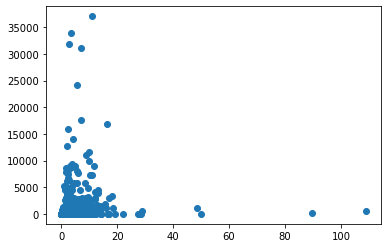

In [14]:
location_data['Case-Fatality_Ratio'].value_counts()
plt.scatter(location_data['Case-Fatality_Ratio'],location_data.Deaths)

3954


Text(0.5, 0, 'Deaths')

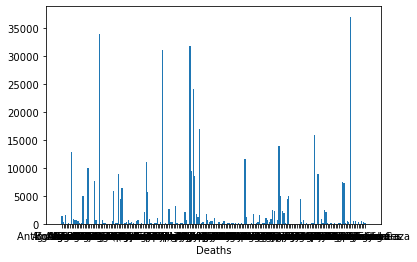

In [15]:
# location_data.loc['US'].plot()
plt.bar(location_data.Country_Region,location_data.Deaths)

print(len(location_data.Deaths))
plt.xlabel('Deaths')

In [13]:
usa = location_data[location_data.Country_Region == 'US']
usa['uid'] = make_identifier(usa[['Lat','Long_','Country_Region']])
usa.head
usa.to_csv(r'usauid.csv')


<AxesSubplot:>

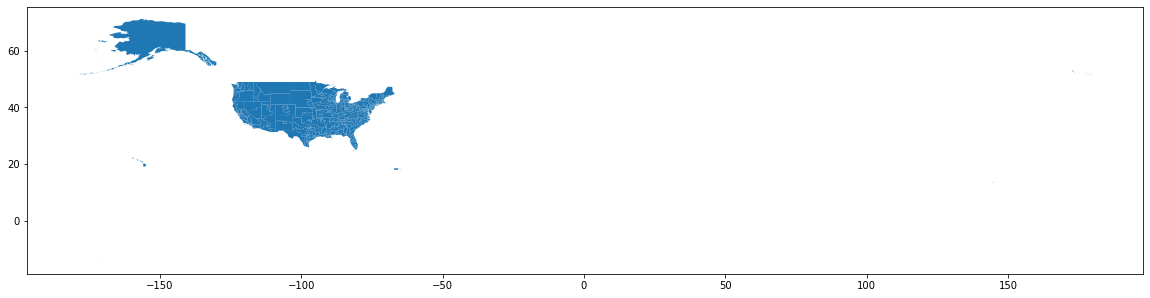

In [18]:
streetmap = gpd.read_file('../shapefiles/us/cb_2018_us_cd116_5m.shp')
fig, ax = plt.subplots(figsize = (20,20))
streetmap.plot(ax=ax)

In [19]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(usa.Long_,usa.Lat)]
geometry[:3]

In [20]:
geo_df = gpd.GeoDataFrame(usa,crs=crs,geometry=geometry)
geo_df.head()
geo_df['Case-Fatality_Ratio'].value_counts()

0.000000    635
2.941176     10
1.515152     10
2.083333      8
1.234568      7
           ... 
1.736569      1
3.968254      1
0.623137      1
3.166405      1
1.920439      1
Name: Case-Fatality_Ratio, Length: 2039, dtype: int64

In [9]:
fig,ax = plt.subplots(figsize = (15,15))
streetmap.plot(ax=ax,alpha = 0.4,color='white')
geo_df[geo_df['Case-Fatality_Ratio'].between(0,1)].plot(ax=ax, markersize=0.1,color='blue',marker='o',label='high')
# geo_df[geo_df['Case-Fatality_Ratio'] < 2].plot(ax=ax, markersize=10,color='red',marker='x',label='low')
# geo_df[geo_df['Case-Fatality_Ratio'] < 2].plot(ax=ax, markersize=10,color='red',marker='x',label='low')
# geo_df[geo_df['Case-Fatality_Ratio'] < 2].plot(ax=ax, markersize=10,color='red',marker='x',label='low')
plt.legend(prop={'size':15})

NameError: name 'streetmap' is not defined

<AxesSubplot:>

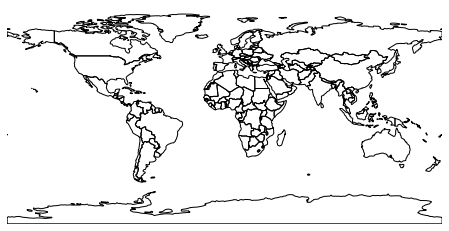

In [51]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gp.polyplot(world,figsize=(8,4))

In [8]:
def visualise_osm_scatter(search_term, title_name, country_code='DE', author_line=True):
    df = run_overpy_query(search_term=search_term, country_code=country_code)
    world = gpd.read_file('PATH\\TO\\SHAPE\\FILE\\FOLDER\\ne_10m_admin_1_states_provinces\\ne_10m_admin_1_states_provinces.shp')
    fig, ax = plt.subplots(figsize=[8, 9.5])
    ax.axis('off')
    world[world['iso_a2']=='DE'].plot(color='w', edgecolor='black', linewidth=0.5, ax=ax)
    ax.scatter(df['lon'], df['lat'], c='red')
    ax.set_title('Location of the {} places\nnamed after {}\n'.format(len(df), title_name),
                 color=(0.41, 0.41, 0.41),
                 size=20)
    #author line
    if author_line:
        fig.text(0.99, 0.01, '@djolay', color='lightgrey', style='italic',
             horizontalalignment='right')

    return fig, ax

In [14]:
crs = {'init': 'epsg:3857'}
daf = {'Brand':['Honda','toyota','kia','civic','civic'],'Lat':[32.93912,72.15332,28.03392,42.50632,12.4],'Long':[62.709952, 22.168302,2.659602,2.521802,56.2]}      
daf2 = {'Brand':['Honda','toyota','kia','civic','Honda'],'Lat':[33.93913,73.15333,123.03393,53.50633,33.20273],'Long':[63.709953, 23.168303,13.659603,9.521803,73.873903]}
daf = pd.DataFrame(daf,columns=['Brand','Lat','Long'])
daf2 = pd.DataFrame(daf2,columns=['Brand','Lat','Long'])
df1 = gpd.GeoDataFrame(daf,crs=crs,geometry=gpd.points_from_xy(daf.Long,daf.Lat))
df22 = gpd.GeoDataFrame(daf2,crs=crs,geometry=gpd.points_from_xy(daf2.Long,daf2.Lat))

In [110]:
# gdf_look = pd.merge(gdf_loctest,gdf_casetest,on='uid',how='inner')
gdf_look.to_csv(r'bothTables.csv')

In [193]:
### attempt to join based on lat and long dist

#projection is done here

coord = {'EPSG':'4326'}
loctest = location_data.head(10)
gdf_loctest = gpd.GeoDataFrame(loctest,crs=crs,geometry=gpd.points_from_xy(loctest.Long_,loctest.Lat))

casetest = cases_train.head(10)
gdf_casetest = gpd.GeoDataFrame(casetest,crs=crs,geometry=gpd.points_from_xy(casetest.longitude,casetest.latitude))



AttributeError: 'DataFrame' object has no attribute 'Long_'

In [210]:
loc_df = loctest
case_df = casetest
radius = 5

In [211]:
loc_df.dropna(subset=['Lat','Long'],inplace=True)
case_df.dropna(subset=['Lat','Long'],inplace=True)

case_gdf = gpd.GeoDataFrame(case_df,crs=crs,geometry=gpd.points_from_xy(case_df.Long,case_df.Lat))
loc_gdf = gpd.GeoDataFrame(loc_df,crs=crs,geometry=gpd.points_from_xy(loc_df.Long,loc_df.Lat))

#drop columns just for now. makes it easier t0 view data
dropCaseCols = ['age', 'sex', 'province', 'date_confirmation',
    'additional_information', 'source', 'outcome']
dropLocCols = ['Province_State','Last_Update','Confirmed','Deaths','Recovered','Active', 'Combined_Key', 'Incidence_Rate','Case-Fatality_Ratio']

case_gdf.drop(columns=dropCaseCols,inplace=True)
loc_gdf.drop(columns=dropLocCols,inplace=True)

case_gdf.geometry= case_gdf.geometry.buffer(radius)
mergeboth_gdf = gpd.sjoin(case_gdf,loc_gdf,how='left')
mergeboth_gdf['dist_between_in_km'] = mergeboth_gdf.apply(lambda row: haversine(row['Long_left'],row['Lat_left'],row['Long_right'],row['Lat_right']),axis=1)
# mergeboth_gdf.to_csv(r'realjoin.csv')

In [212]:
print(case_gdf)
print("\n\n")
loc_gdf

       country        Lat       Long  uid  \
0        India  28.614740  77.209100    0   
1        India  25.436090  81.847180    1   
2        India  18.504220  73.853020    2   
3      Germany  48.120860   7.849500    3   
4        India  23.188409  73.647122    4   
5        India  19.200000  72.966670    5   
6        India  22.716220  75.865120    6   
7      Germany  48.400770  11.743760    7   
8        India  23.027760  72.600270    8   
9  Switzerland  46.298856   8.808264    9   

                                            geometry  
0  POLYGON ((82.20910 28.61474, 82.18502 28.12465...  
1  POLYGON ((86.84718 25.43609, 86.82310 24.94600...  
2  POLYGON ((78.85302 18.50422, 78.82894 18.01413...  
3  POLYGON ((12.84950 48.12086, 12.82542 47.63077...  
4  POLYGON ((78.64712 23.18841, 78.62305 22.69832...  
5  POLYGON ((77.96667 19.20000, 77.94259 18.70991...  
6  POLYGON ((80.86512 22.71622, 80.84104 22.22613...  
7  POLYGON ((16.74376 48.40077, 16.71968 47.91068...  
8  POLYGO

Country_Region       Lat        Long  LatLongID  uid  \
0          Afghanistan  33.93911   67.709953          0    0   
1              Albania  41.15330   20.168300          1    1   
2              Algeria  28.03390    1.659600          2    2   
3              Andorra  42.50630    1.521800          3    3   
4               Angola -11.20270   17.873900          4    4   
5  Antigua and Barbuda  17.06080  -61.796400          5    5   
6            Argentina -38.41610  -63.616700          6    6   
7              Armenia  40.06910   45.038200          7    7   
8            Australia -35.47350  149.012400          8    8   
9            Australia -33.86880  151.209300          9    9   

                      geometry  
0    POINT (67.70995 33.93911)  
1    POINT (20.16830 41.15330)  
2     POINT (1.65960 28.03390)  
3     POINT (1.52180 42.50630)  
4   POINT (17.87390 -11.20270)  
5   POINT (-61.79640 17.06080)  
6  POINT (-63.61670 -38.41610)  
7    POINT (45.03820 40.06910)  
8  POINT (149.01240 -35.47350)  
9  POINT (151.20930 -33.86880)

In [213]:
mergeboth_gdf

country   Lat_left  Long_left  uid_left  \
0        India  28.614740  77.209100         0   
1        India  25.436090  81.847180         1   
2        India  18.504220  73.853020         2   
3      Germany  48.120860   7.849500         3   
4        India  23.188409  73.647122         4   
5        India  19.200000  72.966670         5   
6        India  22.716220  75.865120         6   
7      Germany  48.400770  11.743760         7   
8        India  23.027760  72.600270         8   
9  Switzerland  46.298856   8.808264         9   

                                            geometry  index_right  \
0  POLYGON ((82.20910 28.61474, 82.18502 28.12465...          NaN   
1  POLYGON ((86.84718 25.43609, 86.82310 24.94600...          NaN   
2  POLYGON ((78.85302 18.50422, 78.82894 18.01413...          NaN   
3  POLYGON ((12.84950 48.12086, 12.82542 47.63077...          NaN   
4  POLYGON ((78.64712 23.18841, 78.62305 22.69832...          NaN   
5  POLYGON ((77.96667 19.20000, 77.94259 18.70991...          NaN   
6  POLYGON ((80.86512 22.71622, 80.84104 22.22613...          NaN   
7  POLYGON ((16.74376 48.40077, 16.71968 47.91068...          NaN   
8  POLYGON ((77.60027 23.02776, 77.57619 22.53767...          NaN   
9  POLYGON ((13.80826 46.29886, 13.78419 45.80877...          NaN   

  Country_Region  Lat_right  Long_right  LatLongID  uid_right  \
0            NaN        NaN         NaN        NaN        NaN   
1            NaN        NaN         NaN        NaN        NaN   
2            NaN        NaN         NaN        NaN        NaN   
3            NaN        NaN         NaN        NaN        NaN   
4            NaN        NaN         NaN        NaN        NaN   
5            NaN        NaN         NaN        NaN        NaN   
6            NaN        NaN         NaN        NaN        NaN   
7            NaN        NaN         NaN        NaN        NaN   
8            NaN        NaN         NaN        NaN        NaN   
9            NaN        NaN         NaN        NaN        NaN   

   dist_between_in_km  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
7                 NaN  
8                 NaN  
9                 NaN

In [206]:
for a in [case_gdf,loc_gdf]:
    a.to_crs(epsg=4326,inplace=True)
    dis = a.distance(a.shift())
    print(dis)


0          NaN
1     0.000000
2     0.000000
3    52.355382
4    50.376003
5     0.000000
6     0.000000
7    49.076128
8    45.934169
9    47.926872
dtype: float64
0           NaN
1     48.085895
2     22.686794
3     14.473056
4     56.143102
5     84.535094
6     55.506756
7    134.036614
8    128.519721
9      2.720557
dtype: float64


In [195]:
print(mergeboth_gdf)

       country   Lat_left  Long_left  uid_left  \
0        India  28.614740  77.209100         0   
1        India  25.436090  81.847180         1   
2        India  18.504220  73.853020         2   
3      Germany  48.120860   7.849500         3   
4        India  23.188409  73.647122         4   
5        India  19.200000  72.966670         5   
6        India  22.716220  75.865120         6   
7      Germany  48.400770  11.743760         7   
8        India  23.027760  72.600270         8   
9  Switzerland  46.298856   8.808264         9   

                                            geometry  index_right  \
0  POLYGON ((87.20910 28.61474, 87.16095 27.63457...          NaN   
1  POLYGON ((91.84718 25.43609, 91.79903 24.45592...          NaN   
2  POLYGON ((83.85302 18.50422, 83.80487 17.52405...          NaN   
3  POLYGON ((17.84950 48.12086, 17.80135 47.14069...          3.0   
4  POLYGON ((83.64712 23.18841, 83.59897 22.20824...          NaN   
5  POLYGON ((82.96667 19.20000, 82.

In [120]:
rad = 15
gdf_casetest.geometry = gdf_casetest.geometry.buffer(rad)
gdf_casetest['in_range'] = 1

gdf_joined = gpd.sjoin(gdf_casetest,gdf_loctest,how='left')
print(gdf_joined)
gdf_joined['dist_between_in_km'] = gdf_joined.apply(lambda row: haversine(row['Long_left'],row['Lat_left'],row['Long_right'],row['Lat_right']),axis=1)
# gdf_joined.drop('geoetry')
gdf_joined.drop('geometry',axis=1).to_csv(r'justljoin.csv',mode='a')

       country   Lat_left  Long_left  uid_left  \
0        India  28.614740  77.209100         0   
1        India  25.436090  81.847180         1   
2        India  18.504220  73.853020         2   
3      Germany  48.120860   7.849500         3   
3      Germany  48.120860   7.849500         3   
4        India  23.188409  73.647122         4   
5        India  19.200000  72.966670         5   
6        India  22.716220  75.865120         6   
7      Germany  48.400770  11.743760         7   
7      Germany  48.400770  11.743760         7   
8        India  23.027760  72.600270         8   
9  Switzerland  46.298856   8.808264         9   
9  Switzerland  46.298856   8.808264         9   

                                            geometry  in_range  index_right  \
0  POLYGON ((92.20910 28.61474, 92.13687 27.14448...         1          0.0   
1  POLYGON ((96.84718 25.43609, 96.77495 23.96583...         1          NaN   
2  POLYGON ((88.85302 18.50422, 88.78079 17.03396...         1

In [215]:
location = location_data
cases = cases_train

In [218]:
ljoinonClosestCoord(cases,location,10)

In [78]:
#meth 2
rad =1
df1.geometry = df1.geometry.buffer(rad)
df1['in_range'] = 'match'

gdf1 = gpd.sjoin(df1,df22,how='left')
gdf1['dist_between_in_km'] = gdf1.apply(lambda row: haversine(row['Long_left'],row['Lat_left'],row['Long_right'],row['Lat_right']),axis=1)

print(gdf1)
# def convert_to_gdf(df1,df2):
#     gdf1 = gpd.GeoDataFrame(df1,crs=crs,geometry=gpd.points_from_xy(df1.Long_,df1.Lat))
# def join_on_coord_func(df1,df2,radius):
#     pass


  Brand_left  Lat_left  Long_left  \
0      Honda  32.93912  62.709952   
0      Honda  32.93912  62.709952   
0      Honda  32.93912  62.709952   
0      Honda  32.93912  62.709952   
1     toyota  72.15332  22.168302   
1     toyota  72.15332  22.168302   
1     toyota  72.15332  22.168302   
1     toyota  72.15332  22.168302   
2        kia  28.03392   2.659602   
2        kia  28.03392   2.659602   
2        kia  28.03392   2.659602   
3      civic  42.50632   2.521802   
3      civic  42.50632   2.521802   
3      civic  42.50632   2.521802   
4      civic  12.40000  56.200000   
4      civic  12.40000  56.200000   
4      civic  12.40000  56.200000   

                                            geometry in_range  index_right  \
0  POLYGON ((126.734 36.035, 126.734 36.033, 126....    match            0   
0  POLYGON ((126.734 36.035, 126.734 36.033, 126....    match            1   
0  POLYGON ((126.734 36.035, 126.734 36.033, 126....    match            3   
0  POLYGON ((126.734 

In [74]:
plain = gdf1.drop('geometry',axis=1)
print(plain)
gdf1.drop('geometry',axis=1).to_csv(r'testjoinespg4326.csv',mode='a')

  Brand_left  Lat_left  Long_left  in_range  index_right Brand_right  \
0      Honda  32.93912  62.709952         1            0       Honda   
0      Honda  32.93912  62.709952         1            4       Honda   
1     toyota  72.15332  22.168302         1            1      toyota   
1     toyota  72.15332  22.168302         1            3       civic   
2        kia  28.03392   2.659602         1            3       civic   
3      civic  42.50632   2.521802         1            3       civic   
4      civic  12.40000  56.200000         1            0       Honda   
4      civic  12.40000  56.200000         1            4       Honda   

   Lat_right  Long_right  
0   33.93913   63.709953  
0   33.20273   73.873903  
1   73.15333   23.168303  
1   53.50633    9.521803  
2   53.50633    9.521803  
3   53.50633    9.521803  
4   33.93913   63.709953  
4   33.20273   73.873903  
